In [1]:
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in /Users/specky3512/anaconda3/lib/python3.7/site-packages (0.0)


In [30]:
import pandas as pd
from datetime import datetime as dt
import numpy as np
import requests
import config
import json
import time
import datetime
import matplotlib.pyplot as plt
from scipy.stats import linregress
import tabletext
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import sys

from pprint import pprint

In [73]:

df = pd.read_csv('data_files/fullplayerstatslist.csv')
covid_playoff = pd.read_csv('data_files/player_stats_2019_pst.csv')

In [74]:
covid_playoff

,Unnamed: 0,First_Name,Last_Name,player_id,Position,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,...,Turnovers,Team,Home_Away,win,Team_points,Min_played,Crowd,Stadium_Cap,game_id,game_date
0,0,Torrey,Craig,c14eba17-879a-461e-9413-bf71a378de6e,G,11,0.0,50.0,60.0,0,...,1,Nuggets,1,1,135,21:25,Covid,1200,6541eb3b-eb31-4f6f-a662-94e9d2640c99,2020-08-17T17:30:00+00:00
1,1,Vlatko,Cancar,957e63a8-d87d-47d2-89cc-416afa292d80,F,0,0.0,0.0,0.0,0,...,0,Nuggets,1,1,135,00:00,Covid,1200,6541eb3b-eb31-4f6f-a662-94e9d2640c99,2020-08-17T17:30:00+00:00
2,2,Mason,Plumlee,9570a938-324f-40e8-92dd-8a4fcf4a953b,F-C,2,0.0,100.0,0.0,2,...,1,Nuggets,1,1,135,10:50,Covid,1200,6541eb3b-eb31-4f6f-a662-94e9d2640c99,2020-08-17T17:30:00+00:00
3,3,Jerami,Grant,5b315e15-6633-4ce2-8200-71b821553314,F,19,87.5,50.0,40.0,3,...,0,Nuggets,1,1,135,39:56,Covid,1200,6541eb3b-eb31-4f6f-a662-94e9d2640c99,2020-08-17T17:30:00+00:00
4,4,Troy,Daniels,562677c1-2a13-4934-a801-a6c88c619e83,G,0,0.0,0.0,0.0,0,...,0,Nuggets,1,1,135,00:00,Covid,1200,6541eb3b-eb31-4f6f-a662-94e9d2640c99,2020-08-17T17:30:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,2692,Anthony,Davis,ea8826b8-1f76-4eab-b61e-ffcb176880f3,C,19,71.4,50.0,0.0,3,...,3,Lakers,0,1,106,35:06,Covid,8000,b56b052b-b341-46c0-916d-16982d80961d,2020-10-11T23:30:00+00:00
2693,2693,Alex,Caruso,8936c15e-f9d5-4b9a-80b9-8f6b7dcf7a17,G,4,0.0,40.0,0.0,5,...,1,Lakers,0,1,106,32:42,Covid,8000,b56b052b-b341-46c0-916d-16982d80961d,2020-10-11T23:30:00+00:00
2694,2694,JaVale,McGee,34ff5b55-42ef-40c0-a2c4-9c28b5476a03,C-F,0,0.0,0.0,0.0,0,...,0,Lakers,0,1,106,00:00,Covid,8000,b56b052b-b341-46c0-916d-16982d80961d,2020-10-11T23:30:00+00:00
2695,2695,Kentavious,Caldwell-Pope,cecc054e-b9ec-4c71-8bbb-5ee665a8c3a9,G,17,100.0,66.7,28.6,0,...,2,Lakers,0,1,106,33:26,Covid,8000,b56b052b-b341-46c0-916d-16982d80961d,2020-10-11T23:30:00+00:00


In [4]:
df


,Unnamed: 0,Unnamed: 0.1,First_Name,Last_Name,player_id,Position,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,...,Turnovers,Team,Home_Away,win,Team_points,Min_played,Crowd,Stadium_Cap,game_id,game_date
0,0,0,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,F,19,50.0,81.818,0.0,...,4,Cavaliers,1,1,117,32:23,20562,20562,0da78f13-73ac-4465-8e31-ecc3029a5dc6,2016-10-25T23:30:00+00:00
1,1,1,James,Jones,09d25155-c3be-4246-a986-55921a1b5e61,G-F,5,100.0,0.000,100.0,...,0,Cavaliers,1,1,117,5:30,20562,20562,0da78f13-73ac-4465-8e31-ecc3029a5dc6,2016-10-25T23:30:00+00:00
2,2,2,J.R.,Smith,5934134d-0d27-42ea-a554-4b0e3e85ce56,G-F,8,0.0,20.000,25.0,...,0,Cavaliers,1,1,117,25:14,20562,20562,0da78f13-73ac-4465-8e31-ecc3029a5dc6,2016-10-25T23:30:00+00:00
3,3,3,Kay,Felder,8d3acdd5-9b5a-4d69-9912-de42d979c31a,G,0,0.0,0.000,0.0,...,0,Cavaliers,1,1,117,00:00,20562,20562,0da78f13-73ac-4465-8e31-ecc3029a5dc6,2016-10-25T23:30:00+00:00
4,4,4,Mike,Dunleavy,4ec1bff7-ec1b-488b-8a24-aed83e62b4ce,G-F,4,0.0,100.000,0.0,...,0,Cavaliers,1,1,117,22:32,20562,20562,0da78f13-73ac-4465-8e31-ecc3029a5dc6,2016-10-25T23:30:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182364,8965,8965,Marial,Shayok,0a530034-a07c-4db3-a99e-17c5254c07e1,G-F,5,100.0,0.000,33.3,...,1,76ers,0,1,134,7:56,Covid,8000,0fca55cb-4bc8-4646-a2e6-75d95a20270b,2020-08-15T01:00:00+00:00
182365,8966,8966,Josh,Richardson,ef11cca9-6605-44e8-943e-193c7b821465,G,5,0.0,50.000,50.0,...,0,76ers,0,1,134,23:18,Covid,8000,0fca55cb-4bc8-4646-a2e6-75d95a20270b,2020-08-15T01:00:00+00:00
182366,8967,8967,Glenn,Robinson III,7f462af0-2ac8-4ca5-aa5a-17b37dc5001b,F,0,0.0,0.000,0.0,...,0,76ers,0,1,134,00:00,Covid,8000,0fca55cb-4bc8-4646-a2e6-75d95a20270b,2020-08-15T01:00:00+00:00
182367,8968,8968,Raul,Neto,8e7ffd66-f779-418c-bf18-b9f746a1c5fe,G,14,71.4,60.000,33.3,...,0,76ers,0,1,134,18:44,Covid,8000,0fca55cb-4bc8-4646-a2e6-75d95a20270b,2020-08-15T01:00:00+00:00


In [76]:
covid_dropped = covid_playoff[covid_playoff['Min_played'] != "00:00"]
# df_dropped = df_dropped[df_dropped['Crowd'] != 'Covid']
# df_dropped = df_dropped[df_dropped['Crowd'] != '0']
covid_dropped= covid_dropped[['First_Name', 'Last_Name', 'player_id', "Points", "Free_Throw_Percent",
                  "Two_Pt_Percent",
                  "Three_Pt_Percent", "Assists",
                  "Rebounds", "Offensive_Rebounds",
                  "Steals", "Personal_Fouls",
                  "Flagrant_Fouls", "Tech_Fouls",
                  "Turnovers",
                  "Home_Away", "win", "Min_played"
                  ]].reset_index(drop = True)
covid_dropped.sort_values(by=["Min_played"], ascending = False)

,First_Name,Last_Name,player_id,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,Rebounds,Offensive_Rebounds,Steals,Personal_Fouls,Flagrant_Fouls,Tech_Fouls,Turnovers,Home_Away,win,Min_played
463,JaKarr,Sampson,7a3749f6-b03a-49eb-9e1d-07b897bd0b2d,2,0.0,33.3,0.0,0,3,0,0,4,0,0,0,0,0,9:56
556,Justin,Anderson,0ffd6d00-1aa4-49e0-a85d-6a538417ff3b,9,0.0,0.0,60.0,1,4,0,0,1,0,0,1,1,0,9:56
1337,Semi,Ojeleye,e9bfd179-878d-4c04-acc7-2ed289d62b65,2,0.0,100.0,0.0,1,1,0,0,0,0,0,0,1,0,9:53
326,Jaylen,Adams,10a4ebb7-7be4-4fda-b7c7-fd20a6e7a6c0,4,0.0,100.0,0.0,2,2,0,0,0,0,0,0,0,0,9:53
364,Miye,Oni,eec2714c-72a5-48c8-bc10-d628e2a583f7,5,0.0,100.0,50.0,0,4,2,0,2,0,0,1,1,1,9:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,Alize,Johnson,247fda9b-09e6-4949-8fe3-acfcb9ed0983,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,00:11
44,Romeo,Langford,cfca106e-f7a4-4ea3-a805-4505a3bf74c6,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,1,00:10
1531,Derrick,Jones Jr.,54cf6e06-9172-44b8-8d3b-ea1b6926553d,0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,00:10
1499,PJ,Dozier,ee06e9d2-98bf-487d-96a5-4954c25b75ef,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,00:04


In [36]:
#dropping Crowd from df_dropped to check status weight v win & try to tweat training % up from 71
df_dropped = df[df['Min_played'] != "00:00"]
df_dropped = df_dropped[df_dropped['Crowd'] != 'Covid']
df_dropped = df_dropped[df_dropped['Crowd'] != '0']
df_dropped= df_dropped[['First_Name', 'Last_Name', 'player_id', "Points", "Free_Throw_Percent",
                  "Two_Pt_Percent",
                  "Three_Pt_Percent", "Assists",
                  "Rebounds", "Offensive_Rebounds",
                  "Steals", "Personal_Fouls",
                  "Flagrant_Fouls", "Tech_Fouls",
                  "Turnovers",
                  "Home_Away", "win", "Min_played"
                  ]].reset_index(drop = True)
df_dropped.sort_values(by=["Min_played"], ascending = False)

,First_Name,Last_Name,player_id,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,Rebounds,Offensive_Rebounds,Steals,Personal_Fouls,Flagrant_Fouls,Tech_Fouls,Turnovers,Home_Away,win,Min_played
71181,Tim,Frazier,005948cb-f744-4928-bf7f-d26076717c99,0,0.0,0.0,0.0,3,2,2,0,2,0,0,0,1,0,9:59
24649,Kenneth,Faried,6ee485e1-534f-4d07-9492-c30b1ae9d607,0,0.0,0.0,0.0,2,2,0,0,3,0,0,0,0,1,9:59
18509,Christian,Wood,98100660-988b-4e71-a89e-f35839964483,5,75.0,50.0,0.0,0,4,3,0,3,0,0,1,0,1,9:59
108206,Michael,Porter Jr.,3a7d6510-00e9-4265-81df-864a1f547269,6,0.0,0.0,50.0,0,1,0,0,0,0,0,3,1,1,9:59
34786,Lavoy,Allen,37ad80b2-c9f4-4fde-b462-e1109f249b56,0,0.0,0.0,0.0,1,2,2,0,1,0,0,0,0,1,9:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14326,Cheick,Diallo,74cddaf3-0435-4adb-83fe-d44ae35e7e4b,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,1,00:01
71536,Marreese,Speights,e4bd8c65-a40b-42e3-8327-6913045bf008,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,1,00:01
116574,Tyson,Chandler,3cd2d1c1-d575-45fd-b069-3f0adf57796d,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,00:01
12927,Jeff,Withey,6c2124da-2ab9-4cad-bd88-224c87e6e6f3,1,50.0,0.0,0.0,0,0,0,0,1,0,0,0,1,1,00:01


In [37]:
df_dropped["Min_played"] = df_dropped["Min_played"].astype(str)

In [38]:
time = df_dropped['Min_played'].str.split(':', n=1, expand=True)
cols = time.columns
time[cols]= time[cols].apply(pd.to_numeric, errors='coerce')
time.dtypes
time['total_sec_played'] = time[0]*60 + time[1]
time = time['total_sec_played']

df_dropped = df_dropped.join(time)
df_dropped



,First_Name,Last_Name,player_id,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,Rebounds,Offensive_Rebounds,Steals,Personal_Fouls,Flagrant_Fouls,Tech_Fouls,Turnovers,Home_Away,win,Min_played,total_sec_played
0,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,19,50.0,81.818,0.0,14,11,3,0,3,0,0,4,1,1,32:23,1943.0
1,James,Jones,09d25155-c3be-4246-a986-55921a1b5e61,5,100.0,0.000,100.0,0,0,0,0,1,0,0,0,1,1,5:30,330.0
2,J.R.,Smith,5934134d-0d27-42ea-a554-4b0e3e85ce56,8,0.0,20.000,25.0,2,3,0,1,1,0,0,0,1,1,25:14,1514.0
3,Mike,Dunleavy,4ec1bff7-ec1b-488b-8a24-aed83e62b4ce,4,0.0,100.000,0.0,2,4,0,3,0,0,0,0,1,1,22:32,1352.0
4,Kevin,Love,7d615ccd-db96-42a3-9a6c-7f18ea25634e,23,75.0,44.444,33.3,2,12,2,3,3,0,0,2,1,1,24:59,1499.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120379,Paul,Millsap,59f6f688-7000-4cf5-a27f-a1980dd86d93,12,0.0,50.000,40.0,3,8,1,1,4,0,0,2,0,0,33:31,2011.0
120380,Jerami,Grant,5b315e15-6633-4ce2-8200-71b821553314,9,100.0,100.000,66.7,0,2,0,0,3,0,0,0,0,0,16:55,1015.0
120381,Jamal,Murray,685576ef-ea6c-4ccf-affd-18916baf4e60,25,100.0,63.600,27.3,5,6,0,1,2,0,0,4,0,0,38:29,2309.0
120382,Nikola,Jokic,f2625432-3903-4f90-9b0b-2e4f63856bb0,14,0.0,87.500,0.0,8,13,2,0,3,0,0,5,0,0,33:43,2023.0


In [93]:
covid_dropped["Min_played"] = covid_dropped["Min_played"].astype(str)
time_covid = covid_dropped['Min_played'].str.split(':', n=1, expand=True)
cols_covid = time_covid.columns
time_covid[cols_covid]= time_covid[cols_covid].apply(pd.to_numeric, errors='coerce')
time_covid.dtypes
time_covid['total_sec_played'] = time_covid[0]*60 + time_covid[1]
time_covid = time_covid['total_sec_played']

covid_dropped = covid_dropped.join(time_covid)



ValueError: columns overlap but no suffix specified: Index(['total_sec_played'], dtype='object')

In [94]:
covid_dropped

,First_Name,Last_Name,player_id,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,Rebounds,Offensive_Rebounds,Steals,Personal_Fouls,Flagrant_Fouls,Tech_Fouls,Turnovers,Home_Away,win,Min_played,total_sec_played
0,Torrey,Craig,c14eba17-879a-461e-9413-bf71a378de6e,11,0.0,50.0,60.0,0,4,2,0,6,0,0,1,1,1,21:25,1285
1,Mason,Plumlee,9570a938-324f-40e8-92dd-8a4fcf4a953b,2,0.0,100.0,0.0,2,6,1,1,3,0,0,1,1,1,10:50,650
2,Jerami,Grant,5b315e15-6633-4ce2-8200-71b821553314,19,87.5,50.0,40.0,3,0,0,1,2,0,0,0,1,1,39:56,2396
3,Monte,Morris,48b05ddf-0a9f-4426-9394-231c54726eaa,14,0.0,66.7,66.7,4,3,0,1,1,0,0,1,1,1,29:19,1759
4,Michael,Porter Jr.,3a7d6510-00e9-4265-81df-864a1f547269,13,0.0,33.3,42.9,1,8,1,0,3,0,0,1,1,1,31:11,1871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,Quinn,Cook,9484b30a-4e6e-4307-8b42-12fa141dee17,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,1:27,87
1685,Anthony,Davis,ea8826b8-1f76-4eab-b61e-ffcb176880f3,19,71.4,50.0,0.0,3,15,4,1,4,0,0,3,0,1,35:06,2106
1686,Alex,Caruso,8936c15e-f9d5-4b9a-80b9-8f6b7dcf7a17,4,0.0,40.0,0.0,5,3,1,1,2,0,0,1,0,1,32:42,1962
1687,Kentavious,Caldwell-Pope,cecc054e-b9ec-4c71-8bbb-5ee665a8c3a9,17,100.0,66.7,28.6,0,2,1,1,5,0,0,2,0,1,33:26,2006


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler


In [18]:
df_dropped.sort_values(by='total_sec_played')
df_dropped.dropna(subset=['total_sec_played'])
df_dropped['total_sec_played'].astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [96]:
lebron_df = df_dropped['player_id']=='0afbe608-940a-4d5d-a1f7-468718c67d91'
lebron_covid = covid_dropped['player_id']=='0afbe608-940a-4d5d-a1f7-468718c67d91'
filter_df = df_dropped[lebron_df]
covid_filter = covid_dropped[lebron_covid]
print(filter_df.shape)
print(covid_filter.shape)
filter_df
covid_filter

(341, 19)
(21, 19)


,First_Name,Last_Name,player_id,Points,Free_Throw_Percent,Two_Pt_Percent,Three_Pt_Percent,Assists,Rebounds,Offensive_Rebounds,Steals,Personal_Fouls,Flagrant_Fouls,Tech_Fouls,Turnovers,Home_Away,win,Min_played,total_sec_played
0,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,19,50.0,81.818,0.0,14,11,3,0,3,0,0,4,1,1,32:23,1943.0
382,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,21,71.4,50.000,33.3,7,8,2,0,2,0,0,5,0,1,38:40,2320.0
618,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,23,63.6,50.000,33.3,9,6,1,1,2,0,0,2,1,1,39:00,2340.0
990,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,19,60.0,55.556,33.3,8,13,3,0,4,0,0,4,1,1,35:51,2151.0
1422,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,30,100.0,61.111,25.0,12,7,1,1,2,0,0,2,1,1,36:22,2182.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118906,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,34,100.0,68.800,60.0,13,12,0,2,2,0,0,6,0,1,36:23,2183.0
119222,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,22,66.7,63.600,40.0,14,7,1,1,1,0,0,3,1,1,33:45,2025.0
119705,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,37,80.0,78.600,14.3,8,8,0,3,4,0,0,4,1,1,36:30,2190.0
119885,LeBron,James,0afbe608-940a-4d5d-a1f7-468718c67d91,28,85.7,45.500,33.3,9,8,2,0,3,0,0,2,0,1,34:31,2071.0


In [98]:
X = filter_df['total_sec_played']
X_covid = covid_filter['total_sec_played']
print(X.shape)
X

(341,)


0         1943.0
382       2320.0
618       2340.0
990       2151.0
1422      2182.0
           ...  
118906    2183.0
119222    2025.0
119705    2190.0
119885    2071.0
120273    2092.0
Name: total_sec_played, Length: 341, dtype: float64

In [99]:
y = filter_df['Points']
y_covid = covid_filter['Points']
print(y.shape)
y.dtype
y


(341,)


0         19
382       21
618       23
990       19
1422      30
          ..
118906    34
119222    22
119705    37
119885    28
120273    29
Name: Points, Length: 341, dtype: int64

In [109]:
def  stats(a, b):
    quartilesval = a.quantile([.25, .5, .75])
    lowerq = quartilesval[.25]
    upperq = quartilesval[.75]
    iqr = upperq-lowerq
    lowerbound = lowerq - (iqr*1.5)
    upperbound = upperq + (iqr*1.5)
    upperoutliers = b.loc[a >= upperbound]
    loweroutliers = b.loc[a <= lowerbound]
    outliers=pd.concat([upperoutliers, loweroutliers])
    print(f'The statistical analysis states that there are {len(outliers)} outliers')
    print(f'the upper bound is {upperbound} and the lower bound is {lowerbound}')
    

def linearregress(x,y,a,b):
    (slope, intercept, rvalue, pvalue, stderr)=linregress(x,y)
    regress_values = x * slope + intercept
    line_eq = 'y=' + str(round(slope,2)) +'x+' + str(round(intercept,2))
    plt.scatter(x,y, color='blue')
    plt.plot(x,regress_values,"r-")
    print(f'The r-square is {rvalue}')
    print(line_eq)
    plt.annotate(line_eq,(a,b),fontsize=15, color='red')
    plt.grid()
    
def linearregress2(x,y,a,b):
    (slope, intercept, rvalue, pvalue, stderr)=linregress(x,y)
    regress_values = x * slope + intercept
    line_eq = 'y=' + str(round(slope,2)) +'x+' + str(round(intercept,2))
    plt.scatter(x,y, color='red')
    plt.plot(x,regress_values,"r-")
    print(f'The r-square is for post Covid is {rvalue}')
    print(line_eq)
    plt.annotate(line_eq,(a,b),fontsize=15, color='green')
    plt.grid()

The statistical analysis states that there are 2 outliers
the upper bound is 44.5 and the lower bound is 8.5
The r-square is 0.3713970946547783
y=0.01x+7.14
The r-square is for post Covid is 0.4533260422465774
y=0.01x+-3.06


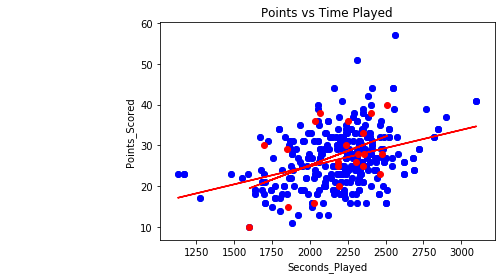

In [110]:
plt.scatter(X,y)
stats(filter_df['Points'], filter_df)
plt.xlabel('Seconds_Played')
plt.ylabel('Points_Scored')
plt.title('Points vs Time Played')
linearregress(X, y, 1, 1)
linearregress2(X_covid, y_covid, 25, 25)


In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)


In [ ]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))



In [ ]:
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_scaled, y_train)
print('k=9 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))
X_test_scaled

In [ ]:
new_iris_data = [[23,75.0,44.444,33.3,2,12,2,3,3,0,0,2,1,1]]
predicted_class = knn.predict(new_iris_data)
print(predicted_class)